<a href="https://colab.research.google.com/github/KevinHern/SemProProject1/blob/master/Dermatology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Enfermedades Dermatológicas

## Miembros
Edy Adolfo Cocon Marroquin - 13001762

Javier Antonio Ferrer Morales - 13000522

Kevin José Hernández Marroquín - 17001095

## Introducción
En la actualidad, para la detección de enfermedades de piel aún se emplean métodos primitivos, como por ejemplo tomar una foto e ir comparando si los síntomas que presenta se asemeja con alguna imagen de algun libro, etc.

Hasta el momento, se ha logrado combinar la ciencia para la detección de dichas enfermedades. Sin embargo, el reto de estas enfermedades de la piel es predecir con certeza qué enfermedad es exactamente.

El reto de los dermatólogos es identificar con exactitud la enfermedad dermatológica que presenta el paciente, ya que la mayoría de los síntomas son muy similares entre varias enfermedades, entonces esto complica mucho a la hora de decidir el veredicto final.

Con este proyecto, atacaremos este reto de clasificar las enfermedades de la piel usando la tecnología y la rama de la Inteligencia Artificial: Machine learning.

## Objetivos
Los objetivos de este proyecto son los siguientes:

*   Encontrar la mejor arquitectura para la clasificación de enfermedades.
*   Demostrar qué tiene más relevancia: únicamente los datos clínicos, únicamente los datos histopatológicos, la combinación de ambos o si la selección de los más importantes entre los datos clínicos e histopatológicos a la hora de detectar qué enfermedad de piel tiene un paciente.



# Librerías

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.math import confusion_matrix
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy import stats
from scipy.stats import norm, skew
from imblearn.over_sampling import SMOTE

from sklearn import preprocessing

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset

## Extracting

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/KevinHern/SemProProject1/master/dermatology.csv', header=0, prefix= "X")

## Getting to know the Dataset

In [0]:
df.columns = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 
               'melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']
df['Classcode'] = df['Classcode'] - 1

In [76]:
df

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,25,3
361,3,2,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,36,3
362,3,2,2,2,3,2,0,2,0,0,0,2,2,0,0,3,3,0,0,0,0,0,0,0,3,0,3,0,3,0,0,2,3,28,2
363,2,1,3,1,2,3,0,2,0,0,0,2,0,0,0,3,2,0,0,0,0,0,0,0,3,0,2,0,1,0,0,2,3,50,2


### Cleaning Dataset

In [65]:
temp = df[df['Age'] != '?']
temp = temp.astype(int)
meanAge = math.floor(temp['Age'].mean())
meanAge

36

In [66]:
df = df.replace('?', meanAge)
df[df['Age'] == '?']

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode


In [67]:
for i in df.columns:
  df[i] = df[i].astype(int)
df.dtypes

erythema                                    int64
scaling                                     int64
definite borders                            int64
itching                                     int64
koebner phenomenon                          int64
polygonal papules                           int64
follicular papules                          int64
oral mucosal involvement                    int64
knee and elbow involvement                  int64
scalp involvement                           int64
history                                     int64
melanin incontinence                        int64
eosinophils in the infiltrate               int64
PNL infiltrate                              int64
fibrosis of the papillary dermis            int64
exocytosis                                  int64
acanthosis                                  int64
hyperkeratosis                              int64
parakeratosis                               int64
clubbing of the rete ridges                 int64


### Is Balanced?

Class 0 :  112
Class 1 :  60
Class 2 :  72
Class 3 :  49
Class 4 :  52
Class 5 :  20


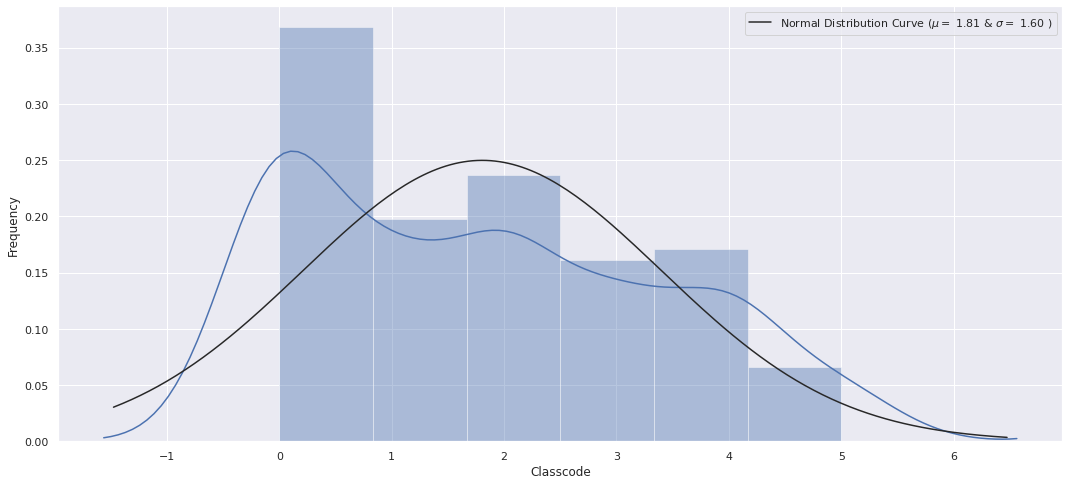

In [79]:
for i in range(6):
  numRows = len(df[df['Classcode'] == i])
  print("Class", i, ": ", numRows)

sns.set(rc={'figure.figsize':(18,8)})
sns.distplot(df['Classcode'], fit=norm)

(mu, sig) = norm.fit(df['Classcode'])
#Now plot the distribution
plt.legend(['Normal Distribution Curve ($\mu=$ {:.2f} & $\sigma=$ {:.2f} )'.format(mu, sig)])
plt.ylabel('Frequency')
plt.show()

### Oversampling Technique

In [78]:
sm = SMOTE(sampling_strategy='auto', random_state=7)
X, Y = sm.fit_sample(df.drop('Classcode', axis=1), df['Classcode'])
temp = pd.concat([pd.DataFrame(X), pd.DataFrame(Y)], axis=1)
temp.columns = df.columns
temp

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3,2,0,0,0,0,2,0,1,0,1,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,2,0,1,2,2,0,11,5
668,2,2,2,0,0,0,1,0,1,0,1,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,1,0,3,2,2,0,9,5
669,2,2,0,0,0,0,2,0,2,0,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,2,2,2,0,7,5
670,2,2,1,0,0,0,2,0,2,0,0,0,0,0,0,2,2,1,2,0,0,0,0,0,0,0,0,0,0,2,2,2,0,7,5


Class 0 :  112
Class 1 :  112
Class 2 :  112
Class 3 :  112
Class 4 :  112
Class 5 :  112


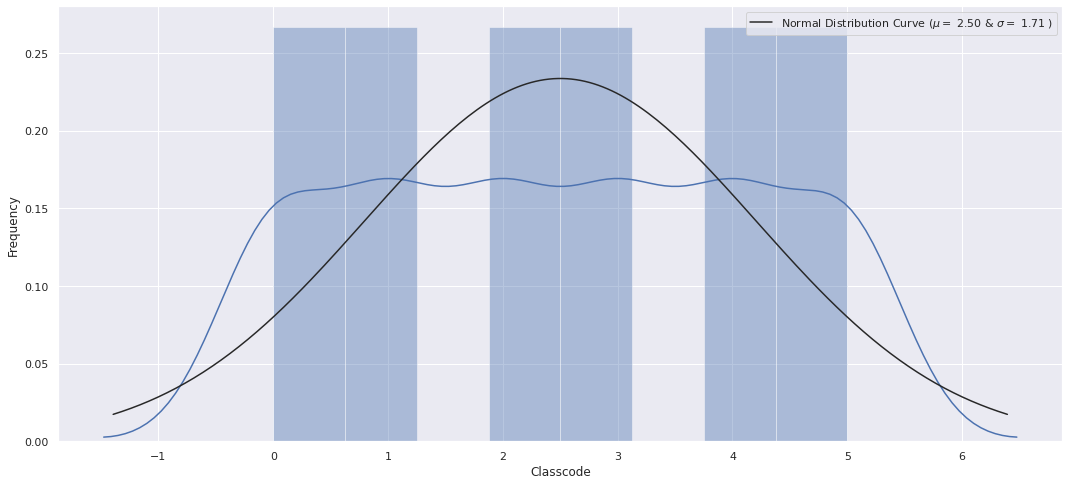

In [81]:
# Checking again
for i in range(6):
  numRows = len(temp[temp['Classcode'] == i])
  print("Class", i, ": ", numRows)

sns.set(rc={'figure.figsize':(18,8)})
sns.distplot(temp['Classcode'], fit=norm)

(mu, sig) = norm.fit(temp['Classcode'])
#Now plot the distribution
plt.legend(['Normal Distribution Curve ($\mu=$ {:.2f} & $\sigma=$ {:.2f} )'.format(mu, sig)])
plt.ylabel('Frequency')
plt.show()



In [83]:
df = temp
df

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3,2,0,0,0,0,2,0,1,0,1,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,2,0,1,2,2,0,11,5
668,2,2,2,0,0,0,1,0,1,0,1,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,1,0,3,2,2,0,9,5
669,2,2,0,0,0,0,2,0,2,0,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,2,2,2,0,7,5
670,2,2,1,0,0,0,2,0,2,0,0,0,0,0,0,2,2,1,2,0,0,0,0,0,0,0,0,0,0,2,2,2,0,7,5



## Correlation

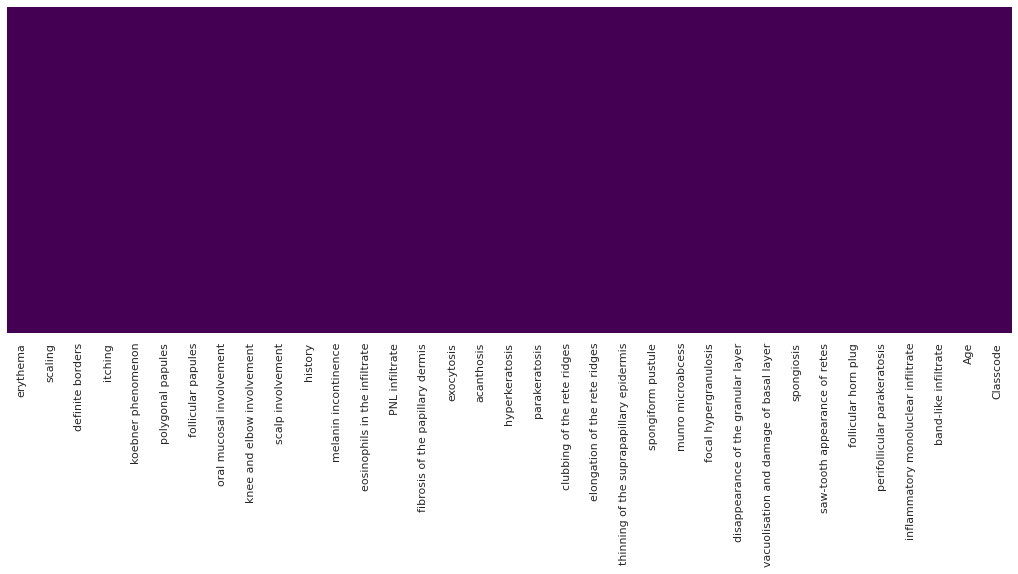

In [84]:
# PLot if there are any null values
plt.figure(figsize=(18,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis', xticklabels=True)

In [0]:
corr = df.corr()

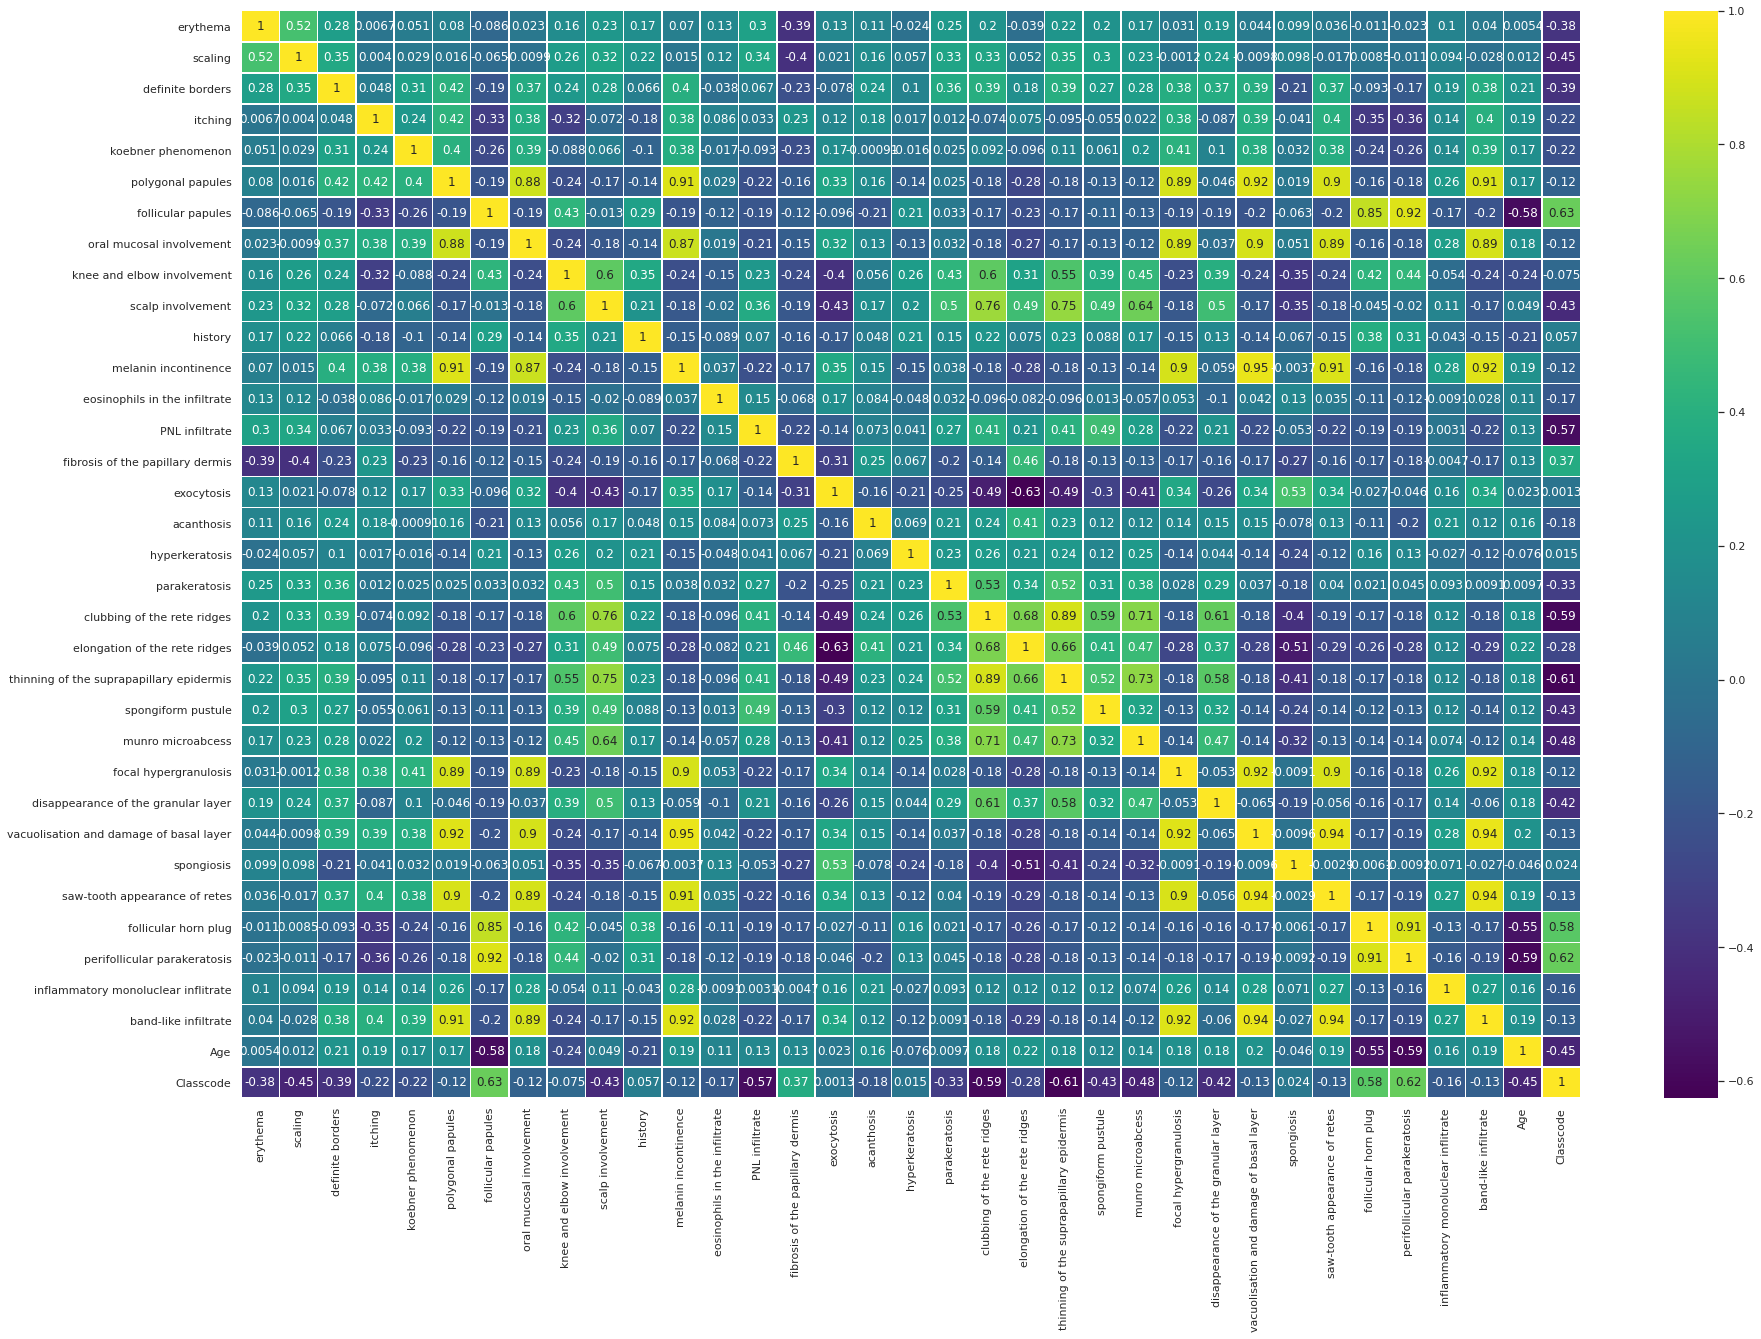

In [86]:
plt.figure(figsize=(30,20))
sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True)

# Models

Metodología:
Queremos ver qué modelo tiene mejor Accuracy utilizando diversos conjuntos de features
Se realizan 4 modelos:

1.   Un modelo que utiliza todos los features del dataset.
2.   Un modelo que utiliza únicamente los features clínicos
3.   Un modelo que utiliza únicamente los datos histopatológicos
4.   Un modelo que utiliza los features más importantes extraídos del heatmap

El approach que se empleará para determinar qué arquitectura es la mejor continene las siguientes condiciones:

*   Los 4 modelos se someterán a los mismos datasets
*   Los 4 modelos tendrán las mismas arquitecturas para ser comparables. Las capas ocultas tendrán neuronas en potencias de 2
*   Se realizarán 4 pruebas, donde cada prueba se utilizará una arquitectura distinta.







## Macro Variables
Definición de variables macros que sirven para los epochs, validation split y batch size

In [0]:
epochs = 5
split = 0.2
batch = 32

## Model Functions

Funciones que serán usados en la definición e implementación de los modelos.
El propósito es disminuir la cantidad de código que se tiene que escribir

#### Models Definitions

In [0]:
# 2 Hidden Layer Model Definition
def model2h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 3 Hidden Layer Model Definition
def model3h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 4 Hidden Layer Model Definition
def model4h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 5 Hidden Layer Model Definition
def model5h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

#### Fit Function

In [0]:
def train_model(model, data, labels):
  print("Training")
  return model.fit(data,
                      labels,
                      epochs=epochs,
                      #validation_data=validation_split,
                      batch_size=batch,
                      validation_split=split
                    )

#### Evaluation Function

In [0]:
def evaluate_model(model, data, labels):
  print("\nEvaluation")
  return model.evaluate(data, labels)

#### Prediction Function

In [0]:
def predictions_model(model, data):
  return model.predict(data)

### Confusion Matrix Function

In [0]:
def compute_confusion_matrix(correct_labels, model_predictions):
  temp_predicts = []
  for prediction in model_predictions:
    temp_predicts.append(np.argmax(prediction))

  temp_predicts

  return confusion_matrix(labels=correct_labels, predictions=temp_predicts)

In [0]:
def plot_confusion_matrix(model_confm):
  figure = plt.figure(figsize=(4, 4))
  sns.heatmap(model_confm, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Splitting Dataset Functions
Funciones que serán usadas para separar el dataset en los distintos sub-datasets para realizar las distintas pruebas .
El propósito es disminuir la cantidad de código que se tiene que escribir

Luego, para cada sub-dataset, lo particionamos en:

*   75% training
*   25% test

Durante el entrenamiento del modelo, el dataset de training se parte en:



*   80% training
*   20% validation



### All Features
Únicamente se separan los labels y los datos

In [0]:
def all_features(dataset):
  
  train_split = dataset.sample(frac = 0.75)
  test_split = dataset.drop(train_split.index)

  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 


### Clinical Features

Se obtienen únicamente los features que son clínicos

In [0]:
clinicalFeatures = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 'Age', 'Classcode']
              
def clinical_features(dataset):
  subset = dataset[clinicalFeatures]

  train_split = subset.sample(frac = 0.75,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Histopathological Features

Se obtienen únicamente los features que son histopatológicos

In [0]:
histFeatures = ['melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']

def histopathological_features(dataset):
  subset = dataset[histFeatures]

  train_split = subset.sample(frac = 0.75)#,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Important Features from the Correlation Heatmap

Se obtienen los features más importantes según el heatmap, para hacer mas sencilla esta operación normalizaremos los datos de la matriz de correlación.

In [100]:
x = corr.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_corr = pd.DataFrame(x_scaled)

print(normalized_corr)

          0         1         2   ...        32        33        34
0   1.000000  0.669941  0.484294  ...  0.255681  0.376157  0.141697
1   0.655039  1.000000  0.534068  ...  0.202772  0.380125  0.094918
2   0.483411  0.553433  1.000000  ...  0.522116  0.504461  0.132535
3   0.286235  0.315165  0.316894  ...  0.535437  0.493632  0.243390
4   0.318405  0.332149  0.507014  ...  0.523163  0.478604  0.239101
5   0.338723  0.323346  0.580774  ...  0.930574  0.479033  0.300657
6   0.219802  0.267947  0.147342  ...  0.068682  0.008832  0.769300
7   0.297726  0.305652  0.545549  ...  0.918367  0.486508  0.302600
8   0.393903  0.493995  0.453953  ...  0.038871  0.221012  0.330833
9   0.448018  0.534693  0.482381  ...  0.095406  0.403593  0.110443
10  0.406040  0.463720  0.329885  ...  0.107154  0.241166  0.412864
11  0.331453  0.322604  0.566596  ...  0.936681  0.492891  0.300824
12  0.378174  0.397488  0.255202  ...  0.246248  0.439016  0.271003
13  0.499552  0.545899  0.330766  ...  0.053058 

In [104]:
normalized_corr.iloc[34]

0     0.008867
1     0.000000
2     0.000000
3     0.107225
4     0.031284
5     0.122665
6     0.765410
7     0.120237
8     0.229756
9     0.000000
10    0.220169
11    0.122458
12    0.000000
13    0.000000
14    0.546920
15    0.385657
16    0.020748
17    0.204542
18    0.000000
19    0.000000
20    0.213669
21    0.000000
22    0.000000
23    0.000000
24    0.125201
25    0.000000
26    0.121233
27    0.354575
28    0.125582
29    0.727208
30    0.764322
31    0.008372
32    0.120772
33    0.087661
34    1.000000
Name: 34, dtype: float64

In [105]:
importantFeatures = []
threshold = 0.1
corIndex = 0
features = corr.columns
for corFeat in normalized_corr.iloc[34]:
  if corFeat >= threshold:
    importantFeatures.append(features[corIndex])
    print(features[corIndex], ":\t", normalized_corr.iloc[34][corIndex])
  corIndex += 1

importantFeatures

itching :	 0.1072252305772263
polygonal papules :	 0.12266521058399066
follicular papules :	 0.7654099141049319
oral mucosal involvement :	 0.12023695752538618
knee and elbow involvement :	 0.22975571945447676
history :	 0.22016877602393864
melanin incontinence :	 0.1224577546898118
fibrosis of the papillary dermis :	 0.5469200617560064
exocytosis :	 0.38565665662781035
hyperkeratosis :	 0.20454192135326404
elongation of the rete ridges :	 0.21366911084241832
focal hypergranulosis :	 0.1252012226813296
vacuolisation and damage of basal layer :	 0.12123290112441125
spongiosis :	 0.3545746524056031
saw-tooth appearance of retes :	 0.12558235826088565
follicular horn plug :	 0.7272077565793382
perifollicular parakeratosis :	 0.764321846886089
band-like infiltrate :	 0.12077240980155159
Classcode :	 1.0


['itching',
 'polygonal papules',
 'follicular papules',
 'oral mucosal involvement',
 'knee and elbow involvement',
 'history',
 'melanin incontinence',
 'fibrosis of the papillary dermis',
 'exocytosis',
 'hyperkeratosis',
 'elongation of the rete ridges',
 'focal hypergranulosis',
 'vacuolisation and damage of basal layer',
 'spongiosis',
 'saw-tooth appearance of retes',
 'follicular horn plug',
 'perifollicular parakeratosis',
 'band-like infiltrate',
 'Classcode']

Con la matriz normalizada, se utiliza un criterio de extraccion de los features que poseen una correlación menor al 90%, dejando fuera aquellos con una correlación mayor o igual a este porcentaje. Este proceso de extracción se realizó mediante una hoja de cálculo.

In [0]:
def heatmap_features(dataset):
  subset = dataset[importantFeatures]

  train_split = subset.sample(frac = 0.75)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

## Model 1: 2 hidden layers

In [0]:
# A matrix where all model 1's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model1 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [134]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model1[0][0] = model2h(train_data.shape[1])
model = summary_model1[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[0][3] = compute_confusion_matrix(test_labels, summary_model1[0][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 18ms/step - loss: 2.2700 - accuracy: 0.4144 - val_loss: 1.0116 - val_accuracy: 0.6139
Epoch 2/5
13/13 [==============================] - 0s 12ms/step - loss: 0.6553 - accuracy: 0.8089 - val_loss: 0.3441 - val_accuracy: 0.8812
Epoch 3/5
13/13 [==============================] - 0s 13ms/step - loss: 0.2346 - accuracy: 0.9454 - val_loss: 0.1922 - val_accuracy: 0.9307
Epoch 4/5
13/13 [==============================] - 0s 13ms/step - loss: 0.1405 - accuracy: 0.9578 - val_loss: 0.2138 - val_accuracy: 0.9406
Epoch 5/5
13/13 [==============================] - 0s 13ms/step - loss: 0.1152 - accuracy: 0.9628 - val_loss: 0.1044 - val_accuracy: 0.9604

Evaluation
6/6 [==============================] - 0s 2ms/step - loss: 0.0925 - accuracy: 0.9583


### Test 2: Clinical Features

In [135]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model1[1][0] = model2h(train_data.shape[1])
model = summary_model1[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[1][3] = compute_confusion_matrix(test_labels, summary_model1[1][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 17ms/step - loss: 2.7297 - accuracy: 0.2556 - val_loss: 1.6535 - val_accuracy: 0.3960
Epoch 2/5
13/13 [==============================] - 0s 13ms/step - loss: 1.2138 - accuracy: 0.5360 - val_loss: 1.1551 - val_accuracy: 0.5842
Epoch 3/5
13/13 [==============================] - 0s 14ms/step - loss: 0.8376 - accuracy: 0.6849 - val_loss: 0.7212 - val_accuracy: 0.6634
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.6545 - accuracy: 0.7717 - val_loss: 0.5258 - val_accuracy: 0.8218
Epoch 5/5
13/13 [==============================] - 0s 14ms/step - loss: 0.5499 - accuracy: 0.8065 - val_loss: 0.4388 - val_accuracy: 0.8812

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.8690


### Test 3: Histopathological Features

In [136]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model1[2][0] = model2h(train_data.shape[1])
model = summary_model1[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[2][3] = compute_confusion_matrix(test_labels, summary_model1[2][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 18ms/step - loss: 1.9549 - accuracy: 0.4318 - val_loss: 0.9309 - val_accuracy: 0.6535
Epoch 2/5
13/13 [==============================] - 0s 13ms/step - loss: 0.6018 - accuracy: 0.8065 - val_loss: 0.4256 - val_accuracy: 0.8416
Epoch 3/5
13/13 [==============================] - 0s 12ms/step - loss: 0.3461 - accuracy: 0.8586 - val_loss: 0.3429 - val_accuracy: 0.8020
Epoch 4/5
13/13 [==============================] - 0s 13ms/step - loss: 0.2609 - accuracy: 0.8933 - val_loss: 0.1898 - val_accuracy: 0.9604
Epoch 5/5
13/13 [==============================] - 0s 14ms/step - loss: 0.2822 - accuracy: 0.8635 - val_loss: 0.2749 - val_accuracy: 0.8812

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.2408 - accuracy: 0.8869


### Test 4: Important Features from the Correlation Heatmap

In [137]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model1[3][0] = model2h(train_data.shape[1])
model = summary_model1[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[3][3] = compute_confusion_matrix(test_labels, summary_model1[3][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 17ms/step - loss: 0.6822 - accuracy: 0.8437 - val_loss: 0.2521 - val_accuracy: 0.9307
Epoch 2/5
13/13 [==============================] - 0s 14ms/step - loss: 0.2206 - accuracy: 0.9057 - val_loss: 0.1450 - val_accuracy: 0.9505
Epoch 3/5
13/13 [==============================] - 0s 13ms/step - loss: 0.1826 - accuracy: 0.9256 - val_loss: 0.1393 - val_accuracy: 0.9604
Epoch 4/5
13/13 [==============================] - 0s 13ms/step - loss: 0.1598 - accuracy: 0.9256 - val_loss: 0.1343 - val_accuracy: 0.9604
Epoch 5/5
13/13 [==============================] - 0s 13ms/step - loss: 0.1602 - accuracy: 0.9305 - val_loss: 0.1542 - val_accuracy: 0.9307

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.9048


## Model 2: 3 hidden layers

In [0]:
# A matrix where all model 2's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model2 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [139]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model2[0][0] = model3h(train_data.shape[1])
model = summary_model2[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[0][3] = compute_confusion_matrix(test_labels, summary_model2[0][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 20ms/step - loss: 1.9641 - accuracy: 0.3995 - val_loss: 0.9364 - val_accuracy: 0.6436
Epoch 2/5
13/13 [==============================] - 0s 15ms/step - loss: 0.5774 - accuracy: 0.8511 - val_loss: 0.5043 - val_accuracy: 0.7426
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.3287 - accuracy: 0.8759 - val_loss: 0.3191 - val_accuracy: 0.8515
Epoch 4/5
13/13 [==============================] - 0s 14ms/step - loss: 0.2162 - accuracy: 0.9156 - val_loss: 0.2211 - val_accuracy: 0.8713
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.1414 - accuracy: 0.9380 - val_loss: 0.1966 - val_accuracy: 0.9109

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9226


### Test 2: Clinical Features

In [140]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model2[1][0] = model3h(train_data.shape[1])
model = summary_model2[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[1][3] = compute_confusion_matrix(test_labels, summary_model2[1][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 20ms/step - loss: 2.1177 - accuracy: 0.3002 - val_loss: 1.6248 - val_accuracy: 0.3663
Epoch 2/5
13/13 [==============================] - 0s 14ms/step - loss: 1.2465 - accuracy: 0.5484 - val_loss: 1.2182 - val_accuracy: 0.6139
Epoch 3/5
13/13 [==============================] - 0s 14ms/step - loss: 0.8838 - accuracy: 0.6923 - val_loss: 0.9055 - val_accuracy: 0.5941
Epoch 4/5
13/13 [==============================] - 0s 16ms/step - loss: 0.7145 - accuracy: 0.7072 - val_loss: 0.6442 - val_accuracy: 0.8119
Epoch 5/5
13/13 [==============================] - 0s 13ms/step - loss: 0.5631 - accuracy: 0.7965 - val_loss: 0.4306 - val_accuracy: 0.8614

Evaluation
6/6 [==============================] - 0s 4ms/step - loss: 0.4730 - accuracy: 0.8214


### Test 3: Histopathological Features

In [141]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model2[2][0] = model3h(train_data.shape[1])
model = summary_model2[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[2][3] = compute_confusion_matrix(test_labels, summary_model2[2][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 20ms/step - loss: 1.7542 - accuracy: 0.4194 - val_loss: 1.0336 - val_accuracy: 0.6832
Epoch 2/5
13/13 [==============================] - 0s 14ms/step - loss: 0.6727 - accuracy: 0.8412 - val_loss: 0.5899 - val_accuracy: 0.7921
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.3555 - accuracy: 0.8759 - val_loss: 0.5488 - val_accuracy: 0.7921
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2763 - accuracy: 0.8908 - val_loss: 0.2745 - val_accuracy: 0.8317
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.2190 - accuracy: 0.9007 - val_loss: 0.3848 - val_accuracy: 0.8812

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8571


### Test 4: Important Features from the Correlation Heatmap

In [142]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model2[3][0] = model3h(train_data.shape[1])
model = summary_model2[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[3][3] = compute_confusion_matrix(test_labels, summary_model2[3][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 20ms/step - loss: 0.7310 - accuracy: 0.7841 - val_loss: 0.2739 - val_accuracy: 0.8713
Epoch 2/5
13/13 [==============================] - 0s 14ms/step - loss: 0.1895 - accuracy: 0.9231 - val_loss: 0.2657 - val_accuracy: 0.8713
Epoch 3/5
13/13 [==============================] - 0s 14ms/step - loss: 0.1628 - accuracy: 0.9330 - val_loss: 0.2328 - val_accuracy: 0.8614
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.1671 - accuracy: 0.9305 - val_loss: 0.2588 - val_accuracy: 0.8515
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.1522 - accuracy: 0.9330 - val_loss: 0.2456 - val_accuracy: 0.8713

Evaluation
6/6 [==============================] - 0s 2ms/step - loss: 0.2178 - accuracy: 0.8929


## Model 3: 4 hidden layers

In [0]:
# A matrix where all model 3's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model3 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [144]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model3[0][0] = model4h(train_data.shape[1])
model = summary_model3[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[0][3] = compute_confusion_matrix(test_labels, summary_model3[0][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 22ms/step - loss: 1.7236 - accuracy: 0.4194 - val_loss: 0.9584 - val_accuracy: 0.7921
Epoch 2/5
13/13 [==============================] - 0s 16ms/step - loss: 0.7129 - accuracy: 0.7667 - val_loss: 0.4858 - val_accuracy: 0.7525
Epoch 3/5
13/13 [==============================] - 0s 17ms/step - loss: 0.3356 - accuracy: 0.8610 - val_loss: 0.4691 - val_accuracy: 0.6931
Epoch 4/5
13/13 [==============================] - 0s 14ms/step - loss: 0.2467 - accuracy: 0.9007 - val_loss: 0.1697 - val_accuracy: 0.9109
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.1308 - accuracy: 0.9479 - val_loss: 0.1428 - val_accuracy: 0.9208

Evaluation
6/6 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9583


### Test 2: Clinical Features

In [145]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model3[1][0] = model4h(train_data.shape[1])
model = summary_model3[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[1][3] = compute_confusion_matrix(test_labels, summary_model3[1][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 21ms/step - loss: 1.9020 - accuracy: 0.2432 - val_loss: 1.5299 - val_accuracy: 0.4257
Epoch 2/5
13/13 [==============================] - 0s 15ms/step - loss: 1.3736 - accuracy: 0.4442 - val_loss: 1.4254 - val_accuracy: 0.4356
Epoch 3/5
13/13 [==============================] - 0s 14ms/step - loss: 1.0333 - accuracy: 0.5955 - val_loss: 0.9616 - val_accuracy: 0.5545
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.8200 - accuracy: 0.6898 - val_loss: 0.6592 - val_accuracy: 0.6733
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.7271 - accuracy: 0.6973 - val_loss: 0.5999 - val_accuracy: 0.7030

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.5605 - accuracy: 0.7381


### Test 3: Histopathological Features

In [146]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model3[2][0] = model4h(train_data.shape[1])
model = summary_model3[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[2][3] = compute_confusion_matrix(test_labels, summary_model3[2][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 21ms/step - loss: 1.7500 - accuracy: 0.2804 - val_loss: 1.3798 - val_accuracy: 0.5545
Epoch 2/5
13/13 [==============================] - 0s 17ms/step - loss: 1.0471 - accuracy: 0.7196 - val_loss: 0.8866 - val_accuracy: 0.8020
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.5845 - accuracy: 0.8164 - val_loss: 0.6483 - val_accuracy: 0.7228
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.3357 - accuracy: 0.8462 - val_loss: 0.3124 - val_accuracy: 0.7327
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2564 - accuracy: 0.8660 - val_loss: 0.2566 - val_accuracy: 0.9109

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.2191 - accuracy: 0.9286


### Test 4: Important Features from the Correlation Heatmap

In [147]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model3[3][0] = model4h(train_data.shape[1])
model = summary_model3[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[3][3] = compute_confusion_matrix(test_labels, summary_model3[3][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 21ms/step - loss: 0.8325 - accuracy: 0.7568 - val_loss: 0.4839 - val_accuracy: 0.8218
Epoch 2/5
13/13 [==============================] - 0s 16ms/step - loss: 0.1972 - accuracy: 0.9032 - val_loss: 0.3348 - val_accuracy: 0.8515
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2417 - accuracy: 0.8859 - val_loss: 0.3129 - val_accuracy: 0.8515
Epoch 4/5
13/13 [==============================] - 0s 14ms/step - loss: 0.2201 - accuracy: 0.8958 - val_loss: 0.3226 - val_accuracy: 0.8515
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2023 - accuracy: 0.9206 - val_loss: 0.3657 - val_accuracy: 0.9010

Evaluation
6/6 [==============================] - 0s 4ms/step - loss: 0.1127 - accuracy: 0.9464


## Model 4: 5 hidden layers

In [0]:
# A matrix where all model 4's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model4 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [149]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model4[0][0] = model5h(train_data.shape[1])
model = summary_model4[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[0][3] = compute_confusion_matrix(test_labels, summary_model4[0][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 21ms/step - loss: 1.6226 - accuracy: 0.3598 - val_loss: 1.1216 - val_accuracy: 0.6634
Epoch 2/5
13/13 [==============================] - 0s 16ms/step - loss: 0.7246 - accuracy: 0.7667 - val_loss: 0.3616 - val_accuracy: 0.9406
Epoch 3/5
13/13 [==============================] - 0s 16ms/step - loss: 0.4008 - accuracy: 0.8486 - val_loss: 0.2770 - val_accuracy: 0.8218
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2614 - accuracy: 0.8834 - val_loss: 0.1893 - val_accuracy: 0.9208
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.1713 - accuracy: 0.9305 - val_loss: 0.1180 - val_accuracy: 0.9604

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.1395 - accuracy: 0.9286


### Test 2: Clinical Features

In [150]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model4[1][0] = model5h(train_data.shape[1])
model = summary_model4[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[1][3] = compute_confusion_matrix(test_labels, summary_model4[1][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 24ms/step - loss: 1.8120 - accuracy: 0.2754 - val_loss: 1.5703 - val_accuracy: 0.3267
Epoch 2/5
13/13 [==============================] - 0s 15ms/step - loss: 1.4153 - accuracy: 0.4913 - val_loss: 1.2030 - val_accuracy: 0.5446
Epoch 3/5
13/13 [==============================] - 0s 16ms/step - loss: 1.0452 - accuracy: 0.5906 - val_loss: 0.8080 - val_accuracy: 0.6238
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.9429 - accuracy: 0.6079 - val_loss: 0.9076 - val_accuracy: 0.6634
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.7657 - accuracy: 0.6849 - val_loss: 0.5979 - val_accuracy: 0.7426

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6726


### Test 3: Histopathological Features

In [151]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model4[2][0] = model5h(train_data.shape[1])
model = summary_model4[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[2][3] = compute_confusion_matrix(test_labels, summary_model4[2][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 23ms/step - loss: 1.7047 - accuracy: 0.2928 - val_loss: 1.4203 - val_accuracy: 0.4356
Epoch 2/5
13/13 [==============================] - 0s 15ms/step - loss: 1.1042 - accuracy: 0.6203 - val_loss: 0.6390 - val_accuracy: 0.7723
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.4657 - accuracy: 0.8412 - val_loss: 0.2991 - val_accuracy: 0.8416
Epoch 4/5
13/13 [==============================] - 0s 17ms/step - loss: 0.2715 - accuracy: 0.8561 - val_loss: 0.2140 - val_accuracy: 0.9208
Epoch 5/5
13/13 [==============================] - 0s 17ms/step - loss: 0.2236 - accuracy: 0.8834 - val_loss: 0.2120 - val_accuracy: 0.8317

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.2291 - accuracy: 0.7976


### Test 4: Important Features from the Correlation Heatmap

In [152]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model4[3][0] = model5h(train_data.shape[1])
model = summary_model4[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[3][3] = compute_confusion_matrix(test_labels, summary_model4[3][2])

Training
Epoch 1/5
13/13 [==============================] - 0s 23ms/step - loss: 0.8160 - accuracy: 0.8288 - val_loss: 0.1855 - val_accuracy: 0.9802
Epoch 2/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2251 - accuracy: 0.9057 - val_loss: 0.2299 - val_accuracy: 0.9208
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.2190 - accuracy: 0.9107 - val_loss: 0.1533 - val_accuracy: 0.9505
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.1927 - accuracy: 0.9231 - val_loss: 0.2004 - val_accuracy: 0.9406
Epoch 5/5
13/13 [==============================] - 0s 16ms/step - loss: 0.1660 - accuracy: 0.9305 - val_loss: 0.1823 - val_accuracy: 0.9109

Evaluation
6/6 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.8810


asdfasdf

# Summary
Resumen de los resultados.


In [0]:
summary_models = [summary_model1, summary_model2, summary_model3, summary_model4]

In [0]:
# Function to print results of a given test
def print_results(testNumber):
  loss = [0 for x in range(4)]
  accuracy = [0 for x in range(4)]

  print("Results:\n\n")
  for i in range(4):
    loss[i] = summary_models[i][testNumber - 1][1][0]
    accuracy[i] = summary_models[i][testNumber - 1][1][1]
    print("Model ", i+1, ": ",
          "\tLoss: ", "{0:.4f}".format(loss[i]),
          "\tAccuracy: ", "{0:.4f}".format(accuracy[i])
          )
    print("Confusion Matrix:")
    plot_confusion_matrix(summary_models[i][testNumber - 1][3])
    print()
  maxAccuracy = max(accuracy)
  minLoss = min(loss)

  print("\nModel With the best Accuracy: ", accuracy.index(maxAccuracy) + 1)
  print("Model with the best loss: ", loss.index(minLoss) + 1)
    

## Test 1 (All Features): Results

Results:


Model  1 :  	Loss:  0.0925 	Accuracy:  0.9583
Confusion Matrix:


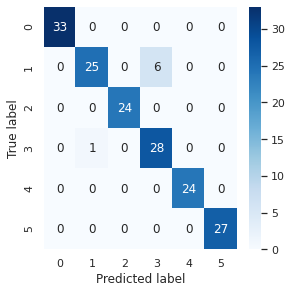


Model  2 :  	Loss:  0.1357 	Accuracy:  0.9226
Confusion Matrix:


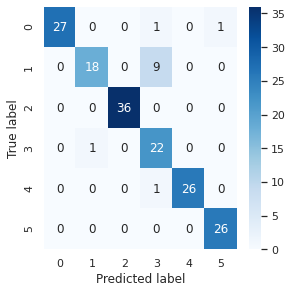


Model  3 :  	Loss:  0.0901 	Accuracy:  0.9583
Confusion Matrix:


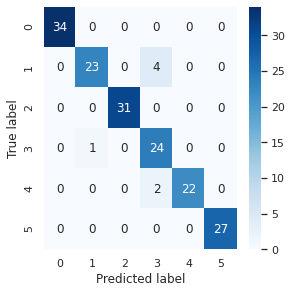


Model  4 :  	Loss:  0.1395 	Accuracy:  0.9286
Confusion Matrix:


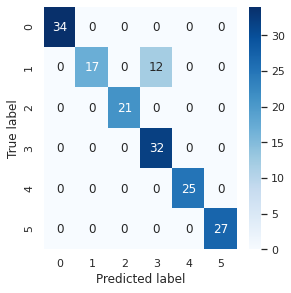



Model With the best Accuracy:  1
Model with the best loss:  3


In [155]:
print_results(1)

## Test 2 (Clinical Features): Results

Results:


Model  1 :  	Loss:  0.4475 	Accuracy:  0.8690
Confusion Matrix:


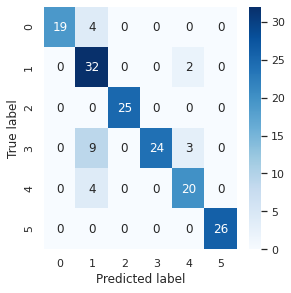


Model  2 :  	Loss:  0.4730 	Accuracy:  0.8214
Confusion Matrix:


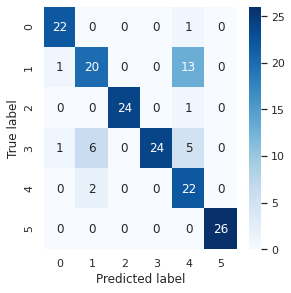


Model  3 :  	Loss:  0.5605 	Accuracy:  0.7381
Confusion Matrix:


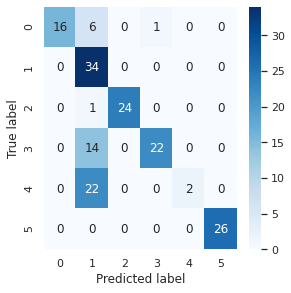


Model  4 :  	Loss:  0.6175 	Accuracy:  0.6726
Confusion Matrix:


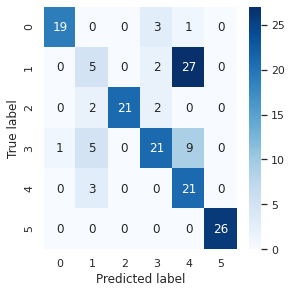



Model With the best Accuracy:  1
Model with the best loss:  1


In [156]:
print_results(2)

## Test 3 (Histopathological Features): Results

Results:


Model  1 :  	Loss:  0.2408 	Accuracy:  0.8869
Confusion Matrix:


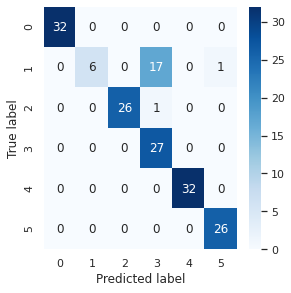


Model  2 :  	Loss:  0.2599 	Accuracy:  0.8571
Confusion Matrix:


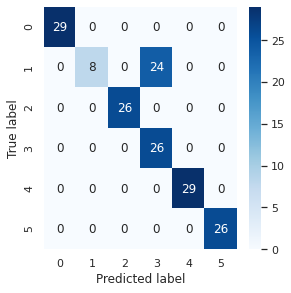


Model  3 :  	Loss:  0.2191 	Accuracy:  0.9286
Confusion Matrix:


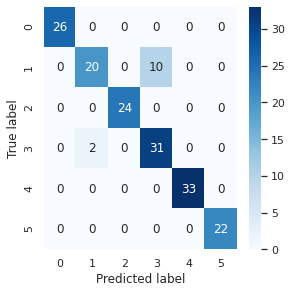


Model  4 :  	Loss:  0.2291 	Accuracy:  0.7976
Confusion Matrix:


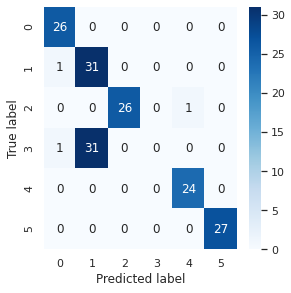



Model With the best Accuracy:  3
Model with the best loss:  3


In [157]:
print_results(3)

## Test 4 (Important Features): Results

Results:


Model  1 :  	Loss:  0.1845 	Accuracy:  0.9048
Confusion Matrix:


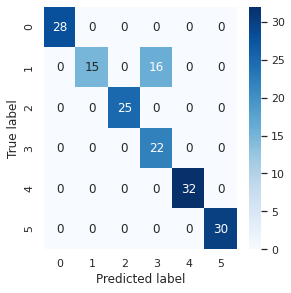


Model  2 :  	Loss:  0.2178 	Accuracy:  0.8929
Confusion Matrix:


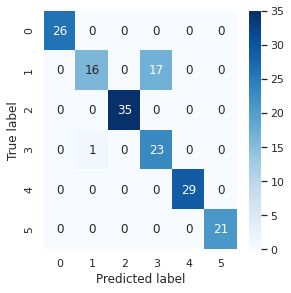


Model  3 :  	Loss:  0.1127 	Accuracy:  0.9464
Confusion Matrix:


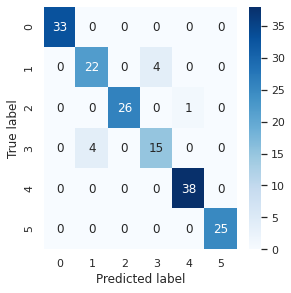


Model  4 :  	Loss:  0.1884 	Accuracy:  0.8810
Confusion Matrix:


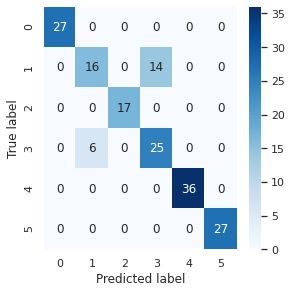



Model With the best Accuracy:  3
Model with the best loss:  3


In [158]:
print_results(4)

# Conclusiones


*   Los Modelos tienen más precisión cuando utilizan tanto los datos Clínicos e Histopatológicos.
*   La mejor arquitectura para este problema es la arquitectura diseñada para el modelo 1; una arquitectura no muy compleja como las otras y relativamente sencilla.



# Hallazgos


*   La arquitectura 1 y la arquitectura 2 tienen desempeños muy similares, sin embargo, la arquitectura 1 tiene la precisión más alta en la mayoría de la pruebas, entonces concluímos que la arquitectura 1 es mejor para este problema.
*   El número de Epochs es muy bajo para el proceso de entrenamiento debido a que el dataset de Training es muy pequeño. De esta forma, evitamos también que los modelos caigan en Overfiting

